In [1]:
from HeaderP import *



In [2]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection




In [3]:
# from So
from os.path import exists
import io
colnames = ['oid','expid','hjd','mjd','mag','magerr','catflags','filtercode',
                     'ra','dec','chi','sharp','filefracday','field','ccdid','qid','limitmag','magzp',
                     'magzprms','clrcoeff','clrcounc','exptime','airmass','programid']
import requests
def download_ztf_archive_lightcurves(ra, dec, objids=[], sr=0.001, lcout=False):
    ra = str(ra)
    dec = str(dec)
    sr = str(sr)
    
    if exists(f"./lc/ra_{ra}_dec_{dec}_sr_{sr}.pkl"):
        mainlc = pd.read_pickle(f"./lc/ra_{ra}_dec_{dec}_sr_{sr}.pkl")
    else:
        url1 = "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE "
        url2 = f"{ra} {dec} {sr}&BANDNAME=r&NOBS_MIN=30&BAD_CATFLAGS_MASK=32768&FORMAT=ipac_table"
        url = url1 + url2


        r = requests.get(url)

        urlData = r.content

        mainlc = pd.read_table(io.StringIO(urlData.decode('utf-8')),
                              delim_whitespace=True, skiprows=54, names=colnames)
        #mainlc.to_pickle(f"./lc/ra_{ra}_dec_{dec}_sr_{sr}.pkl")
    
    return mainlc

    

In [4]:
import io
import os
from astropy.timeseries import LombScargle
import warnings
warnings.filterwarnings('ignore')

def fitpoly(t,mag):
    p = fitpoints(t,mag,2)
    return t, mag-p(t)



def movingMed_time(t, mag, T_window,delta_T_window):
    # add in two columns for the median and put Nan's in them
    t_med=np.empty(len(mag))
    mag_med=np.empty(len(mag))
    t_med[:]=np.nan
    mag_med[:]=np.nan
    
    # define the boundaries of the windows
    window_min=float(min(t))
    window_max=float(window_min+delta_T_window)
    # max time
    maxtime=max(t)
    # break when time window hits the end
    while window_max<=maxtime+T_window:
        seldf=((t>=window_min) & (t<=window_max)) # get points between the window
        
        t_med[seldf]=np.median(t[seldf]) # all values for these indices are subsituded with median time
        mag_med[seldf]=np.median(mag[seldf]) # all values for these indices are subsituded with median flux

        window_min=window_min+delta_T_window
        window_max=window_max+delta_T_window
    return t_med, mag_med

import time
def processlc(maincord, searchradius=5, magrange=1, pltorg=False, splitlc=True, autls=True,
             protmeas=np.linspace(1,200,500),savefigname=[],falarm=False):
    # search radius is arcmin
    colnames = ['oid','expid','hjd','mjd','mag','magerr','catflags','filtercode',
                     'ra','dec','chi','sharp','filefracday','field','ccdid','qid','limitmag','magzp',
                     'magzprms','clrcoeff','clrcounc','exptime','airmass','programid']
    
    t1 = time.perf_counter()
    mainlc = download_ztf_archive_lightcurves(maincord[0], maincord[1], sr=0.001, lcout=True)
    mainlc = mainlc.loc[mainlc['oid']==mainlc['oid'][0]].reset_index(drop=True)
    mainlc = mainlc.dropna(subset=['mjd','mag','magerr']).reset_index(drop=True)
    ######### quality flags below this line #########
    mainlc = mainlc.loc[mainlc['airmass']<1.8].reset_index(drop=True)
    mainlc = mainlc.loc[mainlc['limitmag']>19.5].reset_index(drop=True)
    if sum(mainlc['mag']>mainlc['limitmag'])>0.5*len(mainlc):
        return np.nan, np.nan, [np.nan], [np.nan], np.nan, [np.nan], 0,0,0


    ######### quality flags above this line #########
    mainlc = mainlc[['oid','mjd','mag','magerr']]
    mainlc = mainlc.sort_values(by='mjd').reset_index(drop=True)
    
    
    lcs = download_ztf_archive_lightcurves(maincord[0], maincord[1], sr=searchradius/60, lcout=True)
    lcs = lcs.dropna(subset=['mjd','mag','magerr']).reset_index(drop=True)
    ######### quality flags below this line #########
    lcs = lcs.loc[lcs['airmass']<1.8].reset_index(drop=True)
    lcs = lcs.loc[lcs['limitmag']>19.5].reset_index(drop=True)
    ######### quality flags above this line #########
    lcs = lcs[['oid','mjd','mag','magerr']]
    t2 = time.perf_counter()
    
    nearlcs = lcs.loc[~lcs['oid'].isin(mainlc['oid'].unique())].reset_index(drop=True)
    m = abs(nearlcs['mag']-np.median(mainlc['mag']))<magrange
    nearlcs = nearlcs[m].reset_index(drop=True)
    nearlc_ids = nearlcs['oid'].unique()
    nearbylcs_no = len(nearlc_ids)
    #print('There are nearby %d lcs...'%(nearbylcs_no))
    
    mags = nearlcs['mag']
    for i in trange(nearbylcs_no):
        m = (nearlcs['oid'] == nearlc_ids[i])
        mags[m] = mags[m]-np.median(mags[m])
        
    nearlcs['mag'] = mags
    
    lctime = mainlc['mjd'].values-min(mainlc['mjd'].values)
    lcmags = mainlc['mag'].values
    lcmags_err = mainlc['magerr'].values
    
    
    if pltorg:
        print('LG orginal lcs...')
        plt.figure(figsize=(30,16))
        plt.subplot(2,3,1)
        plt.plot(lctime, lcmags, 'ro', markersize=10, label='pre process')
        plt.xlabel('Time [days]')
        plt.ylabel('Magnitude')
        plt.ylim([min(lcmags),max(lcmags)])
        plt.gca().invert_yaxis()
        plt.title('Origenal lc',fontsize=25)
        
        
        if autls:
            frequency, power = LombScargle(lctime * u.day, lcmags * u.mag, 
                                       lcmags_err * u.mag).autopower()
            prots = 1/frequency
            
        else:
            prots = protmeas*u.day
            frequency = 1/prots
            power = LombScargle(lctime * u.day, lcmags * u.mag, 
                                       lcmags_err * u.mag).power(frequency)
        best_frequency = frequency[np.argmax(power)]
        medpower_org = np.median(power)
        
        plt.subplot(2,3,2)
        P = 1/best_frequency
        t_fold=(lctime-np.median(lctime))-np.round((lctime-np.median(lctime))/P.value)*P.value
        plt.plot(t_fold,  lcmags, 'ko', markersize=10)   
        t_fold, mag = zip(*sorted(zip(t_fold, lcmags)))
        plt.xlabel('Period [Day]')
        plt.ylabel('Power')
        plt.tight_layout()
        plt.ylim([min(lcmags),max(lcmags)])
        plt.title('Prot = %.2f days'%(P.value), fontsize=25)
        plt.gca().invert_yaxis()
        
        plt.subplot(2,3,3)
        plt.semilogx(1/frequency, power, 'k-')   
        plt.xlim(1,200)
        plt.xlabel('Period [Day]')
        plt.ylabel('Power')
        plt.ylim([0,max(power)])
        plt.title('(ra, dec) = ('+str(maincord[0])+', '+str(maincord[1])+')',fontsize=25)
        plt.tight_layout()       
    else:
        if autls:
            frequency, power = LombScargle(lctime * u.day, lcmags * u.mag, 
                                       lcmags_err * u.mag).autopower()
            prots = 1/frequency
            
        else:
            prots = protmeas*u.day
            frequency = 1/prots
            power = LombScargle(lctime * u.day, lcmags * u.mag, 
                                       lcmags_err * u.mag).power(frequency)
        best_frequency = frequency[np.argmax(power)]
        medpower_org = np.median(power)
        
    """
    timediff = np.append([0], np.diff(lctime))
    m = (timediff>0.003)|(timediff==0)
    lctime, lcmags, lcmags_err = lctime[m], lcmags[m], lcmags_err[m]
    """
    timediff = np.append([0], np.diff(lctime))
    if splitlc:
        splits_m = (timediff>80)
        numb_splits = int(sum(splits_m))
        splittimes = lctime[splits_m]
        #print('splitting into %d lcs...'%(numb_splits+1))
        if (numb_splits)==0:
            #print('no lc to split...')
            splitlc=False
        
    
    lcmags = lcmags-np.median(lcmags)
     
    nearlc_time = nearlcs['mjd'].values-min(mainlc['mjd'].values)
    nearlc_mag = nearlcs['mag'].values
    
    lcmags_new = np.zeros(len(lctime))
    for i in range(len(lctime)):
        m = (nearlc_time == lctime[i])
        if sum(m)==0:
            lcmags_new[i] = lcmags[i]
        else:
            lcmags_new[i] = lcmags[i]-np.median(nearlc_mag[m])
    lcmags_new = lcmags_new-np.median(lcmags_new)
    
    if splitlc:
        lctime_sing, lcmags_sing, lcmags_err_sing = [], [], []
        for i in range(-1, numb_splits+1):
            if i==0:
                msplit = (lctime<splittimes[0])
            elif i==(numb_splits):
                msplit = (lctime>=splittimes[i-1])
            elif i==-1:
                msplit = (lctime>0)
            else:
                msplit = (lctime>=splittimes[i-1])&(lctime<splittimes[i])

            
            if sum(msplit)<30:
                continue
            # split into single season + overall ones
            lctime_sing1, lcmags_new_sing1, lcmags_err_sing1 = lctime[msplit], lcmags_new[msplit], lcmags_err[msplit]
            
            # get rid of outliers
            good_ind = abs(lcmags_new_sing1-np.median(lcmags_new_sing1))<3*np.std(lcmags_new_sing1)
            lctime_sing1, lcmags_new_sing1, lcmags_err_sing1 = lctime_sing1[good_ind], lcmags_new_sing1[good_ind], lcmags_err_sing1[good_ind]
            
            # 
            lctime_sing.append(lctime_sing1)
            lcmags_sing.append(lcmags_new_sing1-np.median(lcmags_new_sing1)) 
            lcmags_err_sing.append(lcmags_err_sing1)
        #print('splitting into %d lcs...'%(len(lctime_sing)))
            
    else:
        lctime_sing, lcmags_sing, lcmags_err_sing = [], [], []
        good_ind = abs(lcmags_new-np.median(lcmags_new))<3*np.std(lcmags_new)
        lctime_sing.append(lctime[good_ind])
        lcmags_sing.append(lcmags_new[good_ind]-np.median(lcmags_new[good_ind])) 
        lcmags_err_sing.append(lcmags_err[good_ind])
        
        
    if pltorg:
        #print('LG post processed lcs...')
        plt.subplot(2,3,4)
        minyylim = 100
        maxylim = -100
        for i in range(len(lctime_sing)):
            plt.plot(lctime_sing[i], lcmags_sing[i], 'o', markersize=10)
            plt.xlabel('Time [days]')
            plt.ylabel('normaized magnitude (post)')
            minyylim = min([minyylim, min(lcmags_sing[i])])
            maxylim = max([maxylim, max(lcmags_sing[i])])
        plt.ylim([minyylim, maxylim])
        plt.gca().invert_yaxis()
        plt.title('Processed lc',fontsize=25)
        
        plt.subplot(2,3,5)
        frequency, power, bestfreq, bestpower, Ps, medpower,fa = [], [], [], [], [], [],[]
        minyylim = 100
        maxylim = -100
        for i in range(len(lctime_sing)):
            ls = LombScargle(lctime_sing[i] * u.day, lcmags_sing[i] * u.mag, 
                                           lcmags_err_sing[i] * u.mag)
            if autls:
                timerange = 1/((max(lctime_sing[i])-min(lctime_sing[i]))/2)
                frequency_1, power_1 = ls.autopower(minimum_frequency=timerange*1/u.day)
                prots = 1/frequency_1

            else:
                prots = protmeas*u.day
                frequency_1 = 1/prots
                power_1 = ls.power(frequency_1)
            best_frequency_1 = frequency_1[np.argmax(power_1)]
            
            P = 1/best_frequency_1
            
            Ps.append(P)
            bestfreq.append(best_frequency_1)
            frequency.append(frequency_1)
            power.append(power_1)
            bestpower.append(max(power_1))
            medpower.append(np.median(power_1))
            fa.append(ls.false_alarm_probability(max(power_1)))
            
            t_fold=(lctime_sing[i]-np.median(lctime_sing[i]))-np.round((lctime_sing[i]-np.median(lctime_sing[i]))/P.value)*P.value
            plt.plot(t_fold/(max(t_fold)-min(t_fold)),  lcmags_sing[i]+0.1*i, 'o', label='Prot=%.2f'%P.value, markersize=10)   
            minyylim = min([minyylim, min(lcmags_sing[i]+0.1*i)])
            maxylim = max([maxylim, max(lcmags_sing[i]+0.1*i)])
            plt.xlabel('Normalized Time [Day]')
            plt.ylabel('Power')
            plt.tight_layout()
            
        
        plt.legend()
        plt.ylim([minyylim-0.05,maxylim+0.05])
        plt.gca().invert_yaxis()
        
        
        plt.subplot(2,3,6)
        maxpower = 0
        for i in range(len(lctime_sing)):
            plt.semilogx(1/frequency[i], power[i], '-')   
            plt.xlim(0,200)
            plt.xlabel('Period [Day]')
            plt.ylabel('Power')
            maxpower = max([maxpower, max(power[i])])
        plt.ylim([0,maxpower])
        plt.title('(ra, dec) = ('+str(maincord[0])+', '+str(maincord[1])+')',fontsize=25)
        plt.tight_layout()
        if len(savefigname)!=0:
            plt.savefig(savefigname)
            plt.close()
        
        
    else:
        frequency, power, bestfreq, bestpower, Ps, medpower, fa = [], [], [], [], [], [], []
        for i in range(len(lctime_sing)):
            ls = LombScargle(lctime_sing[i] * u.day, lcmags_sing[i] * u.mag, 
                                           lcmags_err_sing[i] * u.mag)
            
            if autls:
                frequency_1, power_1 = ls.autopower(minimum_frequency=0.005*1/u.day)
                prots = 1/frequency_1
                

            else:
                prots = protmeas*u.day
                frequency_1 = 1/prots
                power_1 = ls.power(frequency_1)
                
            best_frequency_1 = frequency_1[np.argmax(power_1)]
            
            P = 1/best_frequency_1
            
            Ps.append(P)
            bestfreq.append(best_frequency_1)
            frequency.append(frequency_1)
            power.append(power_1)
            bestpower.append(max(power_1))
            medpower.append(np.median(power_1))
            fa.append(ls.false_alarm_probability(power_1))
            
            t_fold=(lctime_sing[i]-np.median(lctime_sing[i]))-np.round((lctime_sing[i]-np.median(lctime_sing[i]))/P.value)*P.value
            t_fold, mag = zip(*sorted(zip(t_fold, lcmags_sing[i])))
            
        
    t3 = time.perf_counter()
    
    if falarm:
        return lctime, lcmags, [i.value for i in Ps], [i.value for i in bestpower], medpower_org, [i.value for i in medpower], [i.value for i in fa], t2-t1, t3-t2, nearbylcs_no

    else:
        return lctime, lcmags, [i.value for i in Ps], [i.value for i in bestpower], medpower_org, [i.value for i in medpower], t2-t1, t3-t2, nearbylcs_no

 
        
    




In [5]:
kepler = pd.read_table('https://arxiv.org/src/1402.5694v2/anc/Table_1_Periodic.txt', delimiter=',')
kepler

gaiakepler = readfits('kepler_dr2_1arcsec.fits')

kepler = pd.merge(kepler, gaiakepler, left_on='KID', right_on='kepid', how='inner')


In [6]:
kepler = kepler.loc[kepler['bp_rp']>1].reset_index(drop=True)
kepler

,KID,Teff,logg_x,Mass,Prot,Prot_err,Rper,LPH,w,DC,...,mass_err2,prov_sec,nconfp,nkoi,ntce,jmag,hmag,kmag,planet?,kepler_gaia_ang_dist
0,892376,3813,4.47,0.4699,1.532,0.007,7306.69,0.823,0.4503,0,...,-0.067,DSEP,0.0,0.0,6.0,11.556,10.927,10.721,none,0.189868
1,1026146,4261,4.57,0.6472,14.891,0.120,11742.56,1.405,0.7229,0,...,-0.051,DSEP,0.0,0.0,0.0,13.589,12.947,12.839,none,0.169890
2,1026474,4122,4.56,0.5914,1.569,0.006,30471.80,1.204,0.6061,0,...,-0.052,DSEP,0.0,0.0,2.0,13.171,12.524,12.382,none,0.159068
3,1162635,3760,4.77,0.4497,15.678,0.019,10207.47,0.978,0.5445,1,...,-0.025,DSEP,0.0,0.0,0.0,13.537,12.898,12.674,none,0.115568
4,1164102,4045,4.62,0.5606,31.496,0.474,5139.74,0.568,0.3939,0,...,-0.059,DSEP,0.0,0.0,0.0,13.275,12.584,12.430,none,0.063042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19881,12934465,4714,4.88,0.7591,34.910,1.692,4572.33,0.433,0.2969,0,...,-0.083,DSEP,0.0,0.0,0.0,13.964,13.404,13.298,none,0.122977
19882,12934525,5278,4.72,0.9062,25.101,0.240,5150.14,0.573,0.4144,0,...,-0.101,DSEP,0.0,0.0,0.0,14.186,13.833,13.781,none,0.090778
19883,12934557,5341,4.58,0.9227,31.226,0.729,1889.88,0.401,0.2511,0,...,-0.102,DSEP,0.0,0.0,0.0,13.047,12.680,12.604,none,0.037766
19884,12984138,4960,4.57,0.8239,12.059,0.038,11734.90,1.194,0.6442,0,...,-0.066,DSEP,0.0,0.0,0.0,14.360,13.809,13.673,none,0.046197


In [8]:
from IPython.display import clear_output
from astropy.coordinates import SkyCoord
import sys

selecstars = 500

ras = kepler['ra'].values[:selecstars]
decs = kepler['dec'].values[:selecstars]
ids = kepler['KID'].values[:selecstars]

filename = 'ztf_kepler'
f = open(filename, 'w+')
f.write('KID,prot1,prot2,prot3,prot4,prot5,prot6,prot7,maxpower1,maxpower2,maxpower3,maxpower4,maxpower5,maxpower6,maxpower7,medpower_org,medpower1,medpower2,medpower3,medpower4,medpower5,medpower6,medpower7,nl\n')
f.flush()
for i in trange(len(ids)):
    clear_output(wait=True)
    print(ras[i], decs[i]) 
    try:
        mainlc = download_ztf_archive_lightcurves(ras[i], decs[i], sr=0.001, 
                                              lcout=True)
    except:
        continue
    
    if len(mainlc)<100:
        try:
            lctime, lcmags, p, maxpower, medpower_org, medpower, dt, tt, nl = processlc([ras[i], decs[i]], 
                  searchradius=4, magrange=2, pltorg=False, splitlc=False, falarm = False)
            plt.close()
        except:
            continue
    else:
        try:
            lctime, lcmags, p, maxpower, medpower_org, medpower, dt, tt, nl = processlc([ras[i], decs[i]], 
              searchradius=4, magrange=2, pltorg=False, falarm = False)
            plt.close()
        except:
            continue

    fline = str(ids[i])
    for j in range(7):
        try:
            fline = fline+','+str(p[j])
        except:
            fline = fline+','+'nan'
    for j in range(7):
        try:
            fline = fline+','+str(maxpower[j])
        except:
            fline = fline+','+'nan'
    fline = fline+','+str(medpower_org)
    for j in range(7):
        try:
            fline = fline+','+str(medpower[j])
        except:
            fline = fline+','+'nan'
        
    f.write(fline+','+str(nl)+'\n')
    f.flush()
                





293.2263137013155 39.21019157743377



100%|██████████| 500/500 [93:48:56<00:00, 675.47s/it]


# Check results

In [70]:
ztf = pd.read_csv('ztf_kepler')

In [71]:
ztf = pd.merge(ztf, kepler[['kepid','Prot']],left_on='KID', right_on='kepid',how='inner')

In [72]:
def getgoodProt(df):
    maxpowers = np.zeros(len(df))
    maxpowerprot = np.zeros(len(df))
    for i in range(len(df)):
        df_sing = df.iloc[i]
        powers = df_sing[['maxpower1','maxpower2','maxpower3','maxpower4',
                                   'maxpower5','maxpower6','maxpower7']].values
        
        maxpowers[i] = max(powers)
        
        maxpowerprot[i] = df_sing[['prot1','prot2','prot3','prot4',
                                   'prot5','prot6','prot7']].values[powers==maxpowers[i]]
        
        
    df['maxpowers'] = maxpowers
    df['maxpowerprot'] = maxpowerprot
    return df

In [73]:
ztf = getgoodProt(ztf)

In [74]:
ztf['maxpowerprot']

0       1.495919
1      14.806258
2       1.564080
3       5.812785
4       1.722602
         ...    
480     4.958947
481     1.021225
482     1.623629
483     7.075661
484     4.329940
Name: maxpowerprot, Length: 485, dtype: float64

Text(0, 0.5, 'ZTF Prot')

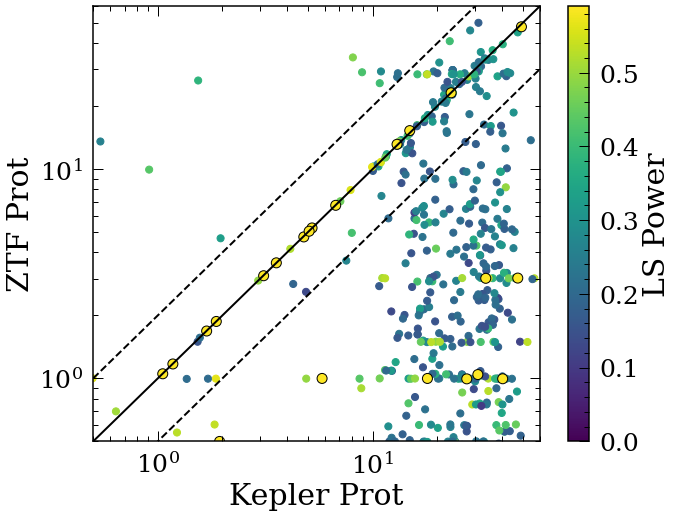

In [92]:
plt.figure(figsize=(10,8))
ztf_filt = ztf.loc[ztf['maxpowers']>0.59]
plt.plot([5e-1,60],[5e-1,60],'k-')
plt.plot([5e-1,60],[5e-1*2,60*2],'k--')
plt.plot([5e-1,60],[5e-1/2,60/2],'k--')
plt.scatter(ztf['Prot'],ztf['maxpowerprot'],c=ztf['maxpowers'],vmin=0,vmax=0.59,
           s=50)
plt.scatter(ztf_filt['Prot'],ztf_filt['maxpowerprot'],c=ztf_filt['maxpowers'],
            vmin=0,vmax=0.59,edgecolor='k',s=100)
plt.xlim([5e-1,60])
plt.ylim([5e-1,60])

cb = plt.colorbar()
cb.set_label('LS Power')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Kepler Prot')
plt.ylabel('ZTF Prot')

In [62]:
ztf = pd.merge(ztf, kepler, left_on='KID', right_on='kepid', how='inner')

Text(0.5, 1.0, 'Kepler')

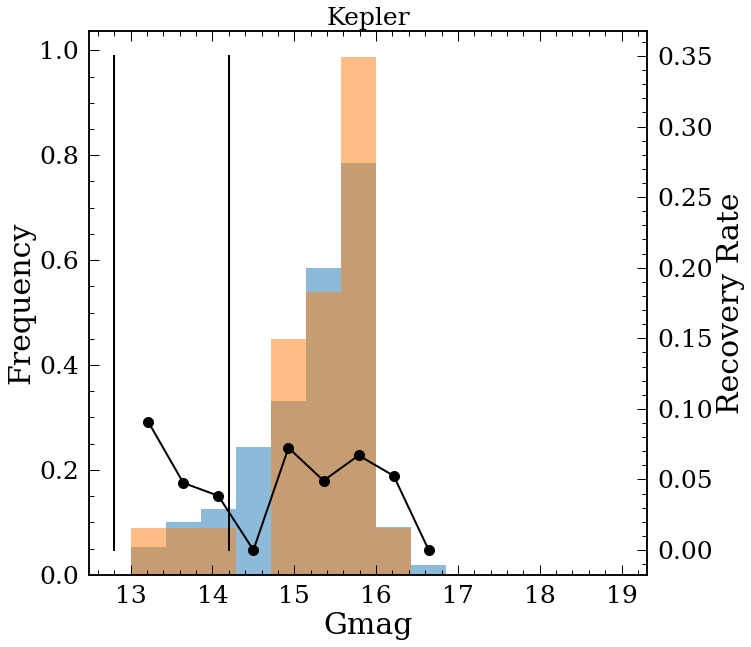

In [68]:
freq1, bin1 = np.histogram(ztf['phot_g_mean_mag'],bins=np.linspace(13,19,15))
plt.hist(ztf['phot_g_mean_mag'],alpha=0.5,bins=np.linspace(13,19,15),label='All',density=True)
LScut=0.59

ztf_filt = ztf.loc[ztf['maxpowers']>0.59]
freq2, bin2 = np.histogram(ztf_filt['phot_g_mean_mag'],bins=np.linspace(13,19,15))
plt.hist(ztf_filt['phot_g_mean_mag'].values,alpha=0.5,bins=np.linspace(13,19,15),label='Recovered',density=True)
plt.ylabel('Frequency')
plt.xlabel('Gmag')

plt.twinx()
plt.plot(np.diff(np.linspace(13,19,15))/2+bin1[:-1],freq2/freq1, 'ko-',
        markersize=10)
plt.plot([14.2,14.2], [0,0.35],'k-')
plt.plot([12.8,12.8], [0,0.35],'k-')
plt.ylabel('Recovery Rate')

plt.title('Kepler', fontsize=25)